In [1]:
import os
import lightgbm as lgb
import pandas as pd
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import optuna
import random

pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
####################################################
############# Setear segun cada maquina ############
#os.chdir("C:/Users/herna/labo3_empresa3_repo/")
#os.chdir("C:/diego_tools/labo3/")
os.chdir("/home/dcastro_contacto/buckets/b1/")
####################################################

In [3]:
experimento = "exp/1/"

In [4]:
arch_train_prefijo = "datasets/emp3_sellout_train_cluster_"
arch_min_max_prod = "datasets/emp3_min_max_prod.csv"
arch_mean_std_prod = "datasets/emp3_mean_std_prod.csv"
arch_prod_ids_prediccion = "datasets/productos_a_predecir.csv"
arch_predicciones_full = experimento + "emp3_lightgbm_prediccion_full.csv"
arch_predicciones_simple = experimento + "emp3_lightgbm_prediccion.csv"

In [5]:
tipos_transf = ['sin_transformacion', 'normalizacion', 'estandarizacion']
GLOBAL_TRANSF = tipos_transf[0]
CANT_ITERACIONES_OPT_BAY = 15
CANT_SEMILLAS = 10
CANT_CLUSTERS = 5
MAX_BIN_PARAM=255
#MAX_BIN_PARAM=1023

GLOBAL_PROD_CUST_IDS = pd.DataFrame() #aca solamente se define, se setea mas abajo

In [6]:
# Marco en train, holdout y descartar para considerarlo en las transformaciones
periodo_inicio=201701 #inclusive
train_periodo_limite = 201810 #inclusive
validate_periodo = 201812
train_all_periodo_limite = 201812 #inclusive
holdout_periodo = 201902

In [7]:
########### NORMALIZACION
def normalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        if (maximo-minimo)==0: 
            return 0
        else:
            return (valor - minimo) / (maximo-minimo)

        
def desnormalizar_valor(valor,minimo,maximo):
    if np.isnan(minimo):
        return valor #si no hay minimo, devuelvo valor original (no tener minimo significa que no habia datos en train)
    else:
        return (valor * (maximo-minimo)) + minimo

def normalizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo min max por producto y lo guardo para poder revertir posteriormente
    df_min_max_prod = df_train.groupby('product_id')['tn'].agg(['max', 'min']).reset_index()
    df_min_max_prod = df_min_max_prod.rename(columns={"min":"valor_1","max":"valor_2"})
    df_min_max_prod.to_csv(arch_min_max_prod, index=False)
        
    df_ret = df_param.merge(df_min_max_prod,how="left",on="product_id") #puede haber productos que no aparezcan, por eso left
    
    # Selecciono columnas a normalizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Normalizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: normalizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

############# ESTANDARIZACION
def estandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        if desvio==0: 
            return 0
        else:
            return (valor - media) / desvio

def desestandarizar_valor(valor,media,desvio):
    if np.isnan(media):
        return valor #si no hay media, devuelvo valor original (no tener media significa que no habia datos en train)
    else:
        return (valor * desvio) + media
    
def estandarizar_tn(df_param):
    #Calculo min max solamente sobre train (para evitar data leakage)
    df_train = df_param[(df_param.periodo<=train_periodo_limite) & (df_param.periodo >= periodo_inicio)]
    df_train = df_train[["product_id","tn"]]
    
    #Calculo media y desvio por producto y lo guardo para poder revertir posteriormente
    df_mean_std_prod = df_train.groupby('product_id')['tn'].agg(['mean', lambda x: np.std(x,ddof=0)]).reset_index() #se usa ddof=0 para evitar NaN cuando hay un solo producto
    df_mean_std_prod.columns = ["product_id",'valor_1', 'valor_2']
    df_mean_std_prod.to_csv(arch_mean_std_prod, index=False)
        
    df_ret = df_param.merge(df_mean_std_prod,how="left",on="product_id")
    
    # Selecciono columnas a estandarizar
    
    # Me guardo la original para comparar
    df_ret["tn_original"]=df_ret.tn
    
    # Dropeo algunas (para evitar ruido)
    cols_remover = ["cust_request_tn","dif_cust_request_tn","cust_request_qty"]
    cols_remover.extend([col for col in df_ret.columns if "cat1_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat2_" in col])
    cols_remover.extend([col for col in df_ret.columns if "cat3_" in col])
        
    df_ret = df_ret.drop(columns=cols_remover)  
    
    # Estandarizo tn, lags y deltas
    lag_cols = [col for col in df_ret.columns if "lag" in col]
    delta_cols = [col for col in df_ret.columns if "delta" in col]
    cols_norm = ["tn","tn_mas_2"]
    cols_norm.extend(lag_cols)
    cols_norm.extend(delta_cols)
                    
    for col_norm in cols_norm:
        df_ret[col_norm] =df_ret.apply(lambda row: estandarizar_valor(row[col_norm],row["valor_1"],row["valor_2"]),axis=1)
    
    return df_ret

################### TRANSFORMACION    
def transformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return normalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return estandarizar_valor(valor,var1,var2)
    else:
        return valor

def destransformar_valor(valor,var1,var2):
    if GLOBAL_TRANSF=="normalizacion":
        return desnormalizar_valor(valor,var1,var2)
    elif GLOBAL_TRANSF=="estandarizacion":
        return desestandarizar_valor(valor,var1,var2)
    else:
        return valor

def graficar_ejemplo_transformacion(df_param):
    df_param = df_param[df_param.product_id==20001]
    
    plt.plot(df_param.tn_original)
    plt.title("Original")
    plt.show()
    
    plt.plot(df_param.tn)
    plt.title("Transformado")
    plt.show()

In [8]:
def semillerio(lgbtrain_all, lgb_params, best_iteration, X_holdout, y_holdout):
    er_holdout_list = []
    y_pred_holdout_list = []

    for i in range(0,CANT_SEMILLAS):
        seed = random.randint(1,99999999999999)
        lgb_params_new = {**lgb_params, **{"seed":seed}}

        final_model = lgb.train(lgb_params_new, lgbtrain_all, num_boost_round=best_iteration)

        y_pred_holdout = final_model.predict(X_holdout)
        er_holdout = error_rate(y_holdout,y_pred_holdout)

        y_pred_holdout_list.append(y_pred_holdout)
        er_holdout_list.append(er_holdout)

    #min(er_holdout_list),max(er_holdout_list),round(np.mean(er_holdout_list),2),round(np.median(er_holdout_list),2), round(np.std(er_holdout_list),2)
    y_pred_holdout_semillerio = np.sum(y_pred_holdout_list,axis=0)/CANT_SEMILLAS
    er_holdout_semillerio = error_rate(y_holdout,y_pred_holdout_semillerio)
    return er_holdout_semillerio

In [9]:
############ DEFINO Vector Global de Productos #################
def actualizar_global_prod_custs(prod_cust_values, y_vector):
    # Ademas del id y los valores para "destransformar", se deja el tn original porque la destransformacion puede no ser
    # precisa para <productos,cliente> que no estaban en train
    GLOBAL_PROD_CUST_IDS = pd.DataFrame(data={"prod_cust":prod_cust_values, "tn_orig":np.array(y_vector)})
    GLOBAL_PROD_CUST_IDS = GLOBAL_PROD_CUST_IDS.merge(df_prod_cust_val1_val2,how="left",on="prod_cust")
    GLOBAL_PROD_CUST_IDS = GLOBAL_PROD_CUST_IDS.sort_values(by="prod_cust",ascending=True)
    
    return GLOBAL_PROD_CUST_IDS

In [10]:
def error_rate(y, y_pred):
    y_pred = np.array(y_pred)
    
    #Solamente destransformo la prediccion (para el y tomo el original de la columna tn_orig)
    df_calculo = GLOBAL_PROD_CUST_IDS.copy()
    df_calculo["y_pred"] = y_pred
    df_calculo["y_pred_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y_pred"],row["valor_1"],row["valor_2"]),axis=1)

    y = df_calculo.tn_orig
    y_pred = df_calculo.y_pred_destransformado
    
    #Las predicciones negativas se convierten a 0
    y_pred = np.maximum(y_pred, 0)
    
    dif_abs = sum(abs(y - y_pred))
    suma_real = sum(y)
    return round(100*dif_abs/suma_real,2)

def lgbm_error_rate(preds, train_data):
    labels = train_data.get_label()
    ret_val = error_rate(labels,preds)
    return 'ER', ret_val, False

In [11]:
def destransformar_vector(y_vector):
    df_calculo = GLOBAL_PROD_CUST_IDS.copy()
    df_calculo["y"] = y_vector
    df_calculo["y_destransformado"]=df_calculo.apply(lambda row: destransformar_valor(row["y"],row["valor_1"],row["valor_2"]),axis=1)

    return df_calculo.y_destransformado

In [12]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show(block=True)
    else:
        print(feat_imp.head(num))
    return feat_imp

In [13]:
def objective(trial):

    lgb_params = {
        'objective': 'regression', 
        'first_metric_only': True,
        'boost_from_average': True,
        'max_depth':-1,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'min_gain_to_split':0.0,
        'force_row_wise':True,
        'feature_pre_filter':False,
        'metric': "None",
        'max_bin': MAX_BIN_PARAM,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01,0.05,0.1,0.2,0.5,0.9]),
        'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
        'feature_fraction': trial.suggest_categorical('feature_fraction', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'bagging_freq':trial.suggest_int('bagging_freq', 1, 10),
        'bagging_fraction': trial.suggest_categorical('bagging_fraction',[0.7,0.75,0.8,0.85,0.9,0.95]),
        'extra_trees':trial.suggest_categorical('extra_trees',[True,False]),
        'verbose':-100,
        'num_threads':-1
    }
    
    lgb_params_num_boost_round = 10000  #un numero muy grande, lo limita early_stopping_rounds
    lgb_params_early_stopping_rounds = int(50 + 5/lgb_params['learning_rate']) #  #el parametro discolo, que depende de otro
    
    lgb_train = lgb.Dataset(data=X_train, label=y_train, feature_name=cols)
    lgb_validate = lgb.Dataset(data=X_validate, label=y_validate, reference=lgb_train, feature_name=cols)
    
    #Train using selected parameters
    model = lgb.train(lgb_params, lgb_train,
                  valid_sets=[lgb_validate],
                  num_boost_round=lgb_params_num_boost_round,
                  early_stopping_rounds=lgb_params_early_stopping_rounds,
                  feval=lgbm_error_rate,
                  verbose_eval=100)
    
    y_pred_validate =model.predict(X_validate) #Create predictions on test set
    er_validate = error_rate(y_validate,y_pred_validate)
    
    GLOBAL_PARAMS_ITER.append(lgb_params)
    GLOBAL_BEST_IT_ITER.append(model.best_iteration)
    GLOBAL_ER_VALIDATE_ITER.append(er_validate)
    GLOBAL_MODEL_ITER.append(model)
    
    return er_validate

In [14]:
##############################################

[I 2023-12-03 13:02:16,459] A new study created in memory with name: no-name-f3988fe7-0aab-406e-bdd9-702f72c0bf66


Cluster: 0
<prod-cust> a validar: 108
<prod-cust> a testear: 120

Sin Transformacion
<prod-cust> a validar: 108
<prod-cust> a testear: 120
Periodos entrenar: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810]
Periodos validar: [201812]
Periodos entrenar ALL: [201701 201702 201703 201704 201705 201706 201707 201708 201709 201710
 201711 201712 201801 201802 201803 201804 201805 201806 201807 201808
 201809 201810 201811 201812]
Periodos holdout: [201902]
X_train: (2376, 31)
y_train: (2376,)

X_validate: (108, 31)
y_validate: (108,)

X_train_all: (2592, 31)
y_train_all: (2592,)

X_holdout: (120, 31)
y_holdout: (120,)
Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 64.03
[200]	valid_0's ER: 51.32
[300]	valid_0's ER: 46.75
[400]	valid_0's ER: 46.68
[500]	valid_0's ER: 47.16
[600]	valid_0's ER: 47.58
[700]	valid_0's ER: 47.9
[800]	valid_0's ER: 48.28


[I 2023-12-03 13:02:21,000] Trial 0 finished with value: 46.47 and parameters: {'learning_rate': 0.01, 'num_leaves': 744, 'feature_fraction': 0.6, 'min_data_in_leaf': 68, 'bagging_freq': 4, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 0 with value: 46.47.


Early stopping, best iteration is:
[329]	valid_0's ER: 46.47
Evaluated only: ER
Training until validation scores don't improve for 75 rounds


[I 2023-12-03 13:02:21,519] Trial 1 finished with value: 45.95 and parameters: {'learning_rate': 0.2, 'num_leaves': 151, 'feature_fraction': 0.5, 'min_data_in_leaf': 66, 'bagging_freq': 10, 'bagging_fraction': 0.7, 'extra_trees': False}. Best is trial 1 with value: 45.95.


[100]	valid_0's ER: 51.61
Early stopping, best iteration is:
[34]	valid_0's ER: 45.95
Evaluated only: ER
Training until validation scores don't improve for 60 rounds


[I 2023-12-03 13:02:21,941] Trial 2 finished with value: 43.89 and parameters: {'learning_rate': 0.5, 'num_leaves': 83, 'feature_fraction': 0.8, 'min_data_in_leaf': 34, 'bagging_freq': 5, 'bagging_fraction': 0.9, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[9]	valid_0's ER: 43.89
Evaluated only: ER
Training until validation scores don't improve for 60 rounds


[I 2023-12-03 13:02:22,275] Trial 3 finished with value: 49.16 and parameters: {'learning_rate': 0.5, 'num_leaves': 70, 'feature_fraction': 0.6, 'min_data_in_leaf': 92, 'bagging_freq': 5, 'bagging_fraction': 0.95, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[5]	valid_0's ER: 49.16
Evaluated only: ER
Training until validation scores don't improve for 75 rounds
[100]	valid_0's ER: 59.56


[I 2023-12-03 13:02:23,016] Trial 4 finished with value: 57.05 and parameters: {'learning_rate': 0.2, 'num_leaves': 747, 'feature_fraction': 0.3, 'min_data_in_leaf': 31, 'bagging_freq': 10, 'bagging_fraction': 0.8, 'extra_trees': True}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[72]	valid_0's ER: 57.05
Evaluated only: ER
Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 62.01
[200]	valid_0's ER: 50.56
[300]	valid_0's ER: 47.03
[400]	valid_0's ER: 46.14
[500]	valid_0's ER: 45.66
[600]	valid_0's ER: 45.92
[700]	valid_0's ER: 46.33
[800]	valid_0's ER: 46.47
[900]	valid_0's ER: 46.64
[1000]	valid_0's ER: 46.86


[I 2023-12-03 13:02:29,937] Trial 5 finished with value: 45.56 and parameters: {'learning_rate': 0.01, 'num_leaves': 962, 'feature_fraction': 0.4, 'min_data_in_leaf': 25, 'bagging_freq': 9, 'bagging_fraction': 0.9, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[526]	valid_0's ER: 45.56
Evaluated only: ER
Training until validation scores don't improve for 100 rounds
[100]	valid_0's ER: 51.46
Early stopping, best iteration is:
[39]	valid_0's ER: 47.72
Evaluated only: ER


[I 2023-12-03 13:02:30,654] Trial 6 finished with value: 47.72 and parameters: {'learning_rate': 0.1, 'num_leaves': 700, 'feature_fraction': 0.3, 'min_data_in_leaf': 46, 'bagging_freq': 5, 'bagging_fraction': 0.8, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Training until validation scores don't improve for 75 rounds
[100]	valid_0's ER: 52.89


[I 2023-12-03 13:02:31,470] Trial 7 finished with value: 51.58 and parameters: {'learning_rate': 0.2, 'num_leaves': 458, 'feature_fraction': 0.4, 'min_data_in_leaf': 94, 'bagging_freq': 7, 'bagging_fraction': 0.7, 'extra_trees': True}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[115]	valid_0's ER: 51.58
Evaluated only: ER
Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 69.19
[200]	valid_0's ER: 57.9
[300]	valid_0's ER: 53.58
[400]	valid_0's ER: 52.34
[500]	valid_0's ER: 51.65
[600]	valid_0's ER: 50.92
[700]	valid_0's ER: 50.3
[800]	valid_0's ER: 49.75
[900]	valid_0's ER: 49.58
[1000]	valid_0's ER: 49.34
[1100]	valid_0's ER: 49.34
[1200]	valid_0's ER: 49.28
[1300]	valid_0's ER: 49.41
[1400]	valid_0's ER: 49.69
[1500]	valid_0's ER: 49.54
[1600]	valid_0's ER: 49.36
[1700]	valid_0's ER: 49.28
Early stopping, best iteration is:
[1176]	valid_0's ER: 49.2
Evaluated only: ER


[I 2023-12-03 13:02:40,272] Trial 8 finished with value: 49.2 and parameters: {'learning_rate': 0.01, 'num_leaves': 554, 'feature_fraction': 0.8, 'min_data_in_leaf': 40, 'bagging_freq': 6, 'bagging_fraction': 0.8, 'extra_trees': True}. Best is trial 2 with value: 43.89.


Training until validation scores don't improve for 550 rounds
[100]	valid_0's ER: 61.86
[200]	valid_0's ER: 50.28
[300]	valid_0's ER: 46.28
[400]	valid_0's ER: 46.52
[500]	valid_0's ER: 46.66
[600]	valid_0's ER: 47.6
[700]	valid_0's ER: 47.16
[800]	valid_0's ER: 47.88


[I 2023-12-03 13:02:44,525] Trial 9 finished with value: 46.23 and parameters: {'learning_rate': 0.01, 'num_leaves': 835, 'feature_fraction': 1.0, 'min_data_in_leaf': 66, 'bagging_freq': 4, 'bagging_fraction': 0.8, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[304]	valid_0's ER: 46.23
Evaluated only: ER
Training until validation scores don't improve for 150 rounds
[100]	valid_0's ER: 52.14
[200]	valid_0's ER: 52.31


[I 2023-12-03 13:02:47,451] Trial 10 finished with value: 51.94 and parameters: {'learning_rate': 0.05, 'num_leaves': 289, 'feature_fraction': 0.9, 'min_data_in_leaf': 6, 'bagging_freq': 1, 'bagging_fraction': 0.9, 'extra_trees': True}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[125]	valid_0's ER: 51.94
Evaluated only: ER
Training until validation scores don't improve for 55 rounds


[I 2023-12-03 13:02:47,937] Trial 11 finished with value: 53.46 and parameters: {'learning_rate': 0.9, 'num_leaves': 985, 'feature_fraction': 0.8, 'min_data_in_leaf': 19, 'bagging_freq': 8, 'bagging_fraction': 0.9, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[1]	valid_0's ER: 53.46
Evaluated only: ER
Training until validation scores don't improve for 60 rounds


[I 2023-12-03 13:02:48,519] Trial 12 finished with value: 54.67 and parameters: {'learning_rate': 0.5, 'num_leaves': 337, 'feature_fraction': 0.4, 'min_data_in_leaf': 22, 'bagging_freq': 8, 'bagging_fraction': 0.9, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[25]	valid_0's ER: 54.67
Evaluated only: ER
Training until validation scores don't improve for 60 rounds


[I 2023-12-03 13:02:49,339] Trial 13 finished with value: 52.72 and parameters: {'learning_rate': 0.5, 'num_leaves': 959, 'feature_fraction': 0.7, 'min_data_in_leaf': 8, 'bagging_freq': 2, 'bagging_fraction': 0.85, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[6]	valid_0's ER: 52.72
Evaluated only: ER
Training until validation scores don't improve for 150 rounds
[100]	valid_0's ER: 46.8
[200]	valid_0's ER: 48.33


[I 2023-12-03 13:02:50,829] Trial 14 finished with value: 46.3 and parameters: {'learning_rate': 0.05, 'num_leaves': 532, 'feature_fraction': 0.8, 'min_data_in_leaf': 32, 'bagging_freq': 8, 'bagging_fraction': 0.75, 'extra_trees': False}. Best is trial 2 with value: 43.89.


Early stopping, best iteration is:
[104]	valid_0's ER: 46.3
Evaluated only: ER
# Experimentos: 15
Mejor experimento: {'learning_rate': 0.5, 'num_leaves': 83, 'feature_fraction': 0.8, 'min_data_in_leaf': 34, 'bagging_freq': 5, 'bagging_fraction': 0.9, 'extra_trees': False}


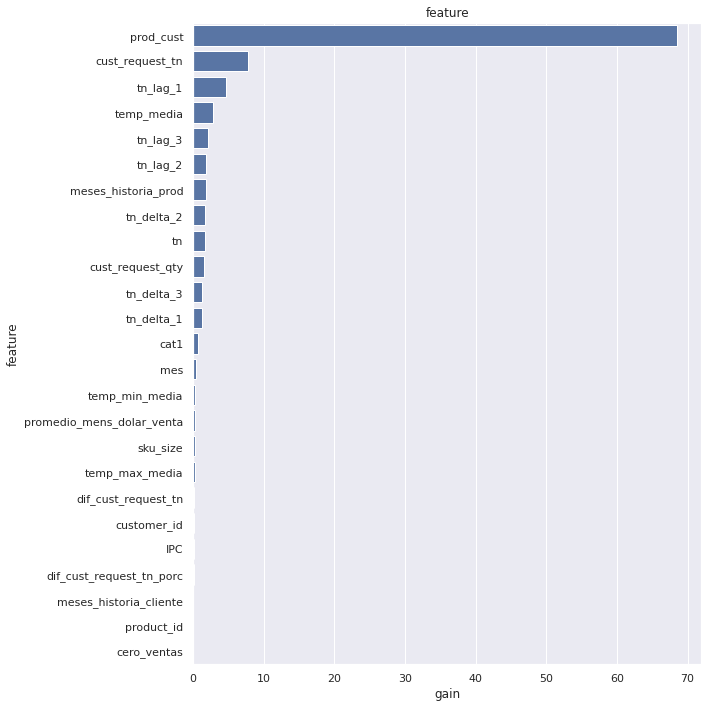

Error Holdout: 60.22


In [18]:
clusters_final_models = []
clusters_er_holdout = []
clusters_predictions = []
clusters_final_params = []
clusters_final_best_iter = []

########################
CANT_CLUSTERS = 0
########################

for cluster_iter in range(0,CANT_CLUSTERS+1):
    print("Cluster:",cluster_iter)
    
    ### Se levanta el dataset de cada cluster
    df_sellout = pd.read_csv(arch_train_prefijo + str(cluster_iter) + ".csv")

    ### Antes de transformar, se guardan los y_validate y holdout originales (se van a usar en el vector global)
    # Esto se debe a que la "destransformacion" no siempre es perfecta, considerando productos que no estuvieron en train
    df_sellout_validate_orig = df_sellout[df_sellout.periodo==validate_periodo]
    df_sellout_validate_orig = df_sellout_validate_orig.sort_values(by="prod_cust",ascending=True)
    y_validate_orig = df_sellout_validate_orig.tn_mas_2
    print("<prod-cust> a validar:", len(y_validate_orig))
    
    df_sellout_holdout_orig = df_sellout[df_sellout.periodo==holdout_periodo]
    df_sellout_holdout_orig = df_sellout_holdout_orig.sort_values(by="prod_cust",ascending=True)
    y_holdout_orig = df_sellout_holdout_orig.tn_mas_2
    print("<prod-cust> a testear:", len(y_holdout_orig))

    ### Transformacion
    if GLOBAL_TRANSF == "sin_transformacion":
        print("\nSin Transformacion")
             
        df_sellout_transf = df_sellout
            
        df_prod_cust_val1_val2 = pd.DataFrame(data={"prod_cust":df_sellout.prod_cust.unique()})
        df_prod_cust_val1_val2["valor_1"]=0
        df_prod_cust_val1_val2["valor_2"]=0
        
#    elif GLOBAL_TRANSF == "normalizacion":
#        print("Normalizacion")
#        print(len(df_sellout))
#        df_sellout_transf = normalizar_tn(df_sellout)
#        print(len(df_sellout_transf))
    
#        graficar_ejemplo_transformacion(df_sellout_transf)
#        df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
        
#        df_prod_cust_val1_val2 = pd.read_csv(arch_min_max_prod)
    
#    elif GLOBAL_TRANSF == "estandarizacion":
#        print("Estandarizacion")
#        df_sellout_transf = estandarizar_tn(df_sellout)
#        graficar_ejemplo_transformacion(df_sellout_transf)
#        df_sellout_transf = df_sellout_transf.drop(columns=["tn_original","valor_1","valor_2"])
       
#        df_prod_cust_val1_val2 = pd.read_csv(arch_mean_std_prod)

    ### Categoricas
    #Transformo todas las categoricas
    categories = ["plan_precios_cuidados","cat1","cat2","cat3","product_id","customer_id","prod_cust","cero_ventas"]
    
    for c in categories: 
        df_sellout_transf[c] = df_sellout_transf[c].astype("category")   
        
    ### Se descartan variables no utiles para la prediccion
    df_sellout_transf = df_sellout_transf.drop(columns=["brand","periodo_fecha"])

    ### Split de datasets
    df_train = df_sellout_transf[(df_sellout_transf.periodo <= train_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
    df_validate = df_sellout_transf[df_sellout_transf.periodo == validate_periodo]
    
    df_train_all = df_sellout_transf[(df_sellout_transf.periodo <= train_all_periodo_limite) & (df_sellout_transf.periodo >= periodo_inicio)]
    df_holdout = df_sellout_transf[df_sellout_transf.periodo == holdout_periodo]
    
    df_validate = df_validate.sort_values(by="prod_cust",ascending=True)
    print("<prod-cust> a validar:", len(df_validate))
    
    df_holdout = df_holdout.sort_values(by="prod_cust",ascending=True)
    print("<prod-cust> a testear:", len(df_holdout))

    print("Periodos entrenar:",df_train.periodo.unique())
    print("Periodos validar:",df_validate.periodo.unique())
    print("Periodos entrenar ALL:",df_train_all.periodo.unique())
    print("Periodos holdout:",df_holdout.periodo.unique())

    ### Armado variables entrenamiento
    # Train - Validate
    X_train = df_train.drop(columns=["tn_mas_2","periodo"], axis=1)
    X_validate = df_validate.drop(columns=["tn_mas_2","periodo"], axis=1)
    
    y_train = df_train.tn_mas_2
    y_validate = df_validate.tn_mas_2
    
    # Train All - Holdout
    X_train_all = df_train_all.drop(columns=["tn_mas_2","periodo"], axis=1)
    X_holdout = df_holdout.drop(columns=["tn_mas_2","periodo"], axis=1)
    
    y_train_all = df_train_all.tn_mas_2
    y_holdout = df_holdout.tn_mas_2
    
    print("X_train:", X_train.shape)
    print("y_train:", y_train.shape)
    
    print("\nX_validate:", X_validate.shape)
    print("y_validate:", y_validate.shape)
    
    print("\nX_train_all:", X_train_all.shape)
    print("y_train_all:", y_train_all.shape)
    
    print("\nX_holdout:", X_holdout.shape)
    print("y_holdout:", y_holdout.shape)

    cols = X_train.columns.tolist()

    ### Optimizacion Bayesiana
    #Antes de entrenar, se setea vector global para validate
    GLOBAL_PROD_CUST_IDS = actualizar_global_prod_custs(X_validate.prod_cust, y_validate_orig)
    
    GLOBAL_PARAMS_ITER = []
    GLOBAL_BEST_IT_ITER = []
    GLOBAL_ER_VALIDATE_ITER = []
    GLOBAL_MODEL_ITER = []
    
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=CANT_ITERACIONES_OPT_BAY)
    print('# Experimentos:', len(study.trials))
    print('Mejor experimento:', study.best_trial.params)

    best_model_index = study.best_trial.number
    best_model = GLOBAL_MODEL_ITER[best_model_index]
    plot_lgb_importances(best_model, num=30, plot=True)

    lgbtrain_all = lgb.Dataset(data=X_train_all, label=y_train_all, feature_name=cols)

    final_params = GLOBAL_PARAMS_ITER[best_model_index]
    final_best_iter = GLOBAL_BEST_IT_ITER[best_model_index]
    final_model = lgb.train(final_params, lgbtrain_all, num_boost_round=final_best_iter)
    
    GLOBAL_PROD_CUST_IDS = actualizar_global_prod_custs(X_holdout.prod_cust, y_holdout_orig)
    
    y_pred_holdout = final_model.predict(X_holdout)
    er_holdout = error_rate(y_holdout,y_pred_holdout)
    print("Error Holdout:", er_holdout)

    prediction_with_prod_cust = pd.DataFrame(data={"prod_cust":X_holdout.prod_cust,"actual_value":y_holdout_orig,"predicted_value":y_pred_holdout})
    
    clusters_final_models.append(final_model)
    clusters_er_holdout.append(er_holdout)
    clusters_predictions.append(prediction_with_prod_cust)
    clusters_final_params.append(final_params)
    clusters_final_best_iter.append(final_best_iter)

In [19]:
clusters_predictions

[        prod_cust  actual_value  predicted_value
 25    20001-10001        364.37           257.35
 61    20001-10002         55.42            10.10
 97    20001-10003        230.00           136.04
 133   20001-10004         91.68           143.32
 169   20001-10005         22.18            19.04
 ...           ...           ...              ...
 3965  20032-10008          0.00             7.54
 3976  20032-10009          6.29            15.66
 3987  20032-10011          0.00             7.55
 3998  20032-10012          0.00            15.66
 4009  20032-10013          0.00             7.55
 
 [120 rows x 3 columns]]

In [ ]:
## Se verifica transformacion
df_test = df_sellout_transf[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]].merge(df_prod_val1_val2,how="left",on="product_id")
df_test["tn"]=df_test.apply(lambda row: destransformar_valor(row["tn"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_mas_2"]=df_test.apply(lambda row: destransformar_valor(row["tn_mas_2"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_lag_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_lag_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test["tn_delta_1"]=df_test.apply(lambda row: destransformar_valor(row["tn_delta_1"],row["valor_1"],row["valor_2"]),axis=1)
df_test = df_test.merge(df_sellout[["product_id","periodo","tn","tn_mas_2","tn_lag_1","tn_delta_1"]],how="inner",on=["product_id","periodo"])
df_test[["product_id","periodo","tn_x","tn_y","tn_mas_2_x","tn_mas_2_y","tn_lag_1_x","tn_lag_1_y","tn_delta_1_x","tn_delta_1_y"]].head()




# Compruebo que no haya diferencias
df_test["dif"]=df_test.tn_x-df_test.tn_y
df_test[df_test.dif>1e-3]



df_test[df_test.tn_x.isna()]


In [ ]:
df_prods_prediccion=pd.read_csv(arch_prod_ids_prediccion)
df_prods_prediccion.head()

In [ ]:
df_prods_prediccion.info()

## Modelo Final

In [ ]:
print(X_holdout.shape)
df_prediccion = X_holdout.copy()
df_prediccion["tn_target"]=np.array(y_holdout_orig)
df_prediccion["tn_predicted"]=np.array(destransformar_vector(y_pred_holdout))
print(df_prediccion.shape)

In [ ]:
print("Toneladas Holdout:\t", df_prediccion.tn_target.sum())
print("Toneladas Prediccion:\t", df_prediccion.tn_predicted.sum())

In [ ]:
df_prediccion = df_prediccion.sort_values(by="product_id",ascending=True)
df_prediccion.to_csv(arch_predicciones_full, index=False)
df_prediccion[["product_id","tn_predicted"]].to_csv(arch_predicciones_simple, index=False)

In [ ]:
print("Error Rate Validate:",GLOBAL_ER_VALIDATE_ITER[best_model_index])
print("Error Rate Holdout:",er_holdout)

In [ ]:
# Armo resultados y calculo modelo final y semillerio para top 5 de error de validacion
df_resultado = pd.DataFrame(data={"error_rate_validation":GLOBAL_ER_VALIDATE_ITER,
                                  "best_iteration": GLOBAL_BEST_IT_ITER,
                                  "params":GLOBAL_PARAMS_ITER})
df_resultado["max_bin"]=MAX_BIN_PARAM

df_resultado = df_resultado.sort_values(by="error_rate_validation",ascending=True)

er_holdout_iter = [None] * len(df_resultado)
er_holdout_semillerio_iter = [None] * len(df_resultado)
for i in range(0,5):
    print("Iteración:",i)
    #Modelo Final (Sin Semillerio)
    final_model = lgb.train(df_resultado.iloc[i].params, lgbtrain_all, num_boost_round=df_resultado.iloc[i].best_iteration)
    y_pred_holdout = final_model.predict(X_holdout)
    er_holdout = error_rate(y_holdout,y_pred_holdout)
    er_holdout_iter[i]=er_holdout
    
    #Semillerio
    er_holdout_semillerio_iter[i]=(semillerio(lgbtrain_all, df_resultado.iloc[i].params, df_resultado.iloc[i].best_iteration, X_holdout, y_holdout))

df_resultado["error_rate_holdout"]=er_holdout_iter    
df_resultado["error_rate_holdout_semillerio"]=er_holdout_semillerio_iter    
    
datetime_string = datetime.datetime.now().strftime('%Y-%m-%d_%H.%M')
df_resultado.to_excel("resultados_opt_bay_"+GLOBAL_TRANSF+"_"+str(CANT_ITERACIONES_OPT_BAY)+"_"+datetime_string+".xlsx",index=False)

In [ ]:
df_resultado

In [ ]:
duration = 500  # 1000 milliseconds = 1 second
winsound.Beep(2000, duration)